In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import random
import time
from math import ceil
import timeit
import pickle
import ipywidgets as widgets

# Summarization and Review

## What are Hashtables? 
Hashtables are useful data structures that allow us to quickly organize, sort, and look up data. They are made up of 4 important things. 
- key
- value
- bins
- hash function which is used to generate bins

## Why do we need it?

In data science, we always come across large data sets and parsing through the data can be a cubersome task when we're searching for something we don't know the location of. The most simplistic way to search for a value in a list of values would be to iterate through it and stop once we find it. With hashtables we can speed up the process and make our lives much easier

## Main Takeaways from today's Session

- Implementation of Linear Search and Hash Tables
- Compare Run times for both
- Look at trends in run times for different bucket sizes vis-a-vis linear search

***

# Problem Statement

Let us revisit our previous scenario. Last week we talked about being in a library and wanting to find books by our favorite author George RR Martin. If we were to go in order and look for each one by one, it would take us forever to find it. By organizing the books into categories, such as the first letter of the authors last name, we can darastically cutdown our search time. This real life model is very similar to a table.

## Data Cleaning and Preparation 

__to be hidden__

In [2]:
df_books =pd.read_csv('books.csv',encoding='ISO-8859-1',on_bad_lines='skip',delimiter=';')

/var/folders/ms/2ygwp03d4b5526gc0h51spqh0000gn/T/ipykernel_33242/2824912780.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books =pd.read_csv('books.csv',encoding='ISO-8859-1',on_bad_lines='skip',delimiter=';')


In [3]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
df_books_to_use = df_books[['Book-Title', 'Book-Author']].copy()

In [5]:
df_books_to_use['Book-Title']= df_books_to_use['Book-Title'].str.lower()

In [6]:
df_books_to_use['Book-Author']= df_books_to_use['Book-Author'].str.lower()

In [7]:
df_books_to_use

,Book-Title,Book-Author
0,classical mythology,mark p. o. morford
1,clara callan,richard bruce wright
2,decision in normandy,carlo d'este
3,flu: the story of the great influenza pandemic...,gina bari kolata
4,the mummies of urumchi,e. j. w. barber
...,...,...
271355,there's a bat in bunk five,paula danziger
271356,from one to one hundred,teri sloat
271357,lily dale : the true story of the town that ta...,christine wicker
271358,republic (world's classics),plato


In [8]:
df_books_to_use.loc[df_books_to_use['Book-Title'].str.contains("game of throne", case=False)]

,Book-Title,Book-Author
4713,"a game of thrones (a song of ice and fire, boo...",george r.r. martin
154334,"a game of thrones (a song of ice and fire, boo...",george r. r. martin
265910,"a game of thrones (a song of ice and fire, boo...",george r.r. martin


In [9]:
df_books_to_use.drop_duplicates(subset=['Book-Title'], inplace=True)

In [10]:
df_books_to_use.sort_index(ascending=False, inplace=True)

In [11]:
df_books_to_use.reset_index(inplace=True, drop=True)

In [12]:
df_books_to_use.loc[df_books_to_use['Book-Title'].str.contains("game of throne", case=False)]

,Book-Title,Book-Author
234411,"a game of thrones (a song of ice and fire, boo...",george r.r. martin


In [13]:
key_value_list = list(zip(df_books_to_use['Book-Title'], df_books_to_use['Book-Author']))
martin_tuple = key_value_list.pop(234411)

In [14]:
def generate_key_value_list(major_list, martin_tuple, num_entries=238964):
    if num_entries > len(major_list) + 1:
        factor = ceil(num_entries / 238964)
        new_major_list = major_list * factor
        return generate_key_value_list(new_major_list,
                                       martin_tuple,
                                       num_entries)
    else:
        list_to_return = random.sample(major_list, num_entries-1)
        list_to_return.append(martin_tuple)
        return list_to_return

In [15]:
def timer_function(func, arg, loops=10):
    start = time.time()
    for i in range(loops):
        func(*arg)
    stop = time.time()
    # returning time in microseconds
    return ((stop-start)*1_000_000)/loops

In [ ]:
all_books_and_authors = generate_key_value_list(key_value_list, martin_tuple, 1_000_000)

In [ ]:
generated_data_sets={}
for n in range(100_000,1_100_000, 100_000):
    generated_data_sets[n] = generate_key_value_list(key_value_list, martin_tuple, n)


In [ ]:
linear_search_time = {}
for key in generated_data_sets:
    dataset = generated_data_sets[key]
    time_value = timer_function(find_in_list,
                                [dataset, GAME_OF_THRONES_BOOK], 10)
    linear_search_time[key] = time_value

In [ ]:
linear_search_time 

{100000: 12359.404563903809,
 200000: 21673.083305358887,
 300000: 31597.304344177246,
 400000: 45144.98710632324,
 500000: 51413.726806640625,
 600000: 59999.918937683105,
 700000: 70080.99555969238,
 800000: 77406.31103515625,
 900000: 87173.08044433594,
 1000000: 98686.50436401367}

In [ ]:
hashtable_search_time = {}
for key in generated_data_sets:
    hashtable_search_time[key]={}
    for bucket_count in [1,2,3,4,5,8,10,50,100,1000]:
        dataset= generated_data_sets[key]
        built_hashtable = populate_hashtable(dataset, bucket_count)
        time_value = timer_function(find_in_hashtable, [built_hashtable, GAME_OF_THRONES_BOOK], 5)
        hashtable_search_time[key][bucket_count] = time_value

In [ ]:
hashtable_search_time[100000]

{1: 12278.985977172852,
 2: 4376.029968261719,
 3: 2808.6185455322266,
 4: 2112.9608154296875,
 5: 1411.7717742919922,
 8: 822.0195770263672,
 10: 650.0244140625,
 50: 134.56344604492188,
 100: 73.00376892089844,
 1000: 18.167495727539062}

In [ ]:
# saved earlier output of this code below
# hashtable_search_time = {}
# for key in generated_data_sets:
#     hashtable_search_time[key]={}
#     for bucket_count in range(1, 3001, 500):
#         dataset= generated_data_sets[key]
#         built_hashtable = populate_hashtable(dataset, bucket_count)
#         time_value = timer_function(find_in_hashtable, [built_hashtable, GAME_OF_THRONES_BOOK], 5)
#         hashtable_search_time[key][bucket_count] = time_value

# with open('experiments_time_hashfinds_big.pickle','wb') as f:
#     pickle.dump(hashtable_search_time, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('experiments_time_hashfinds_final.pickle','wb') as f:
    pickle.dump(hashtable_search_time, f, protocol=pickle.HIGHEST_PROTOCOL)

# List Implementation (Linear Search)

Let us simulate the example of searching for a book in the library without any form of organization. 

In [16]:
def find_in_list(object_list, book_name):
    """
    Find the book_name entry in the object list tuples.
    Parameters:
        object_list: list[tup[str,str]]
        book_name: str
    Returns:
        Return value is the
        ('Book-Title','Book-Author') tuple from the object_list
    """
    book_name = book_name.lower()
    for entry in object_list:
        if book_name == entry[0]:
            return entry
    return (0, 0)

In [60]:
all_books_and_authors[-1]

('a game of thrones (a song of ice and fire, book 1)', 'george r.r. martin')

In [19]:
GAME_OF_THRONES_BOOK = martin_tuple[0]

In [20]:
GAME_OF_THRONES_BOOK

'a game of thrones (a song of ice and fire, book 1)'

In [61]:
%%timeit
find_in_list(all_books_and_authors, GAME_OF_THRONES_BOOK)

110 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
timer_function(find_in_list, [all_books_and_authors, GAME_OF_THRONES_BOOK], 7 )

109642.43752615793

In [ ]:
with open('linear_search_times_final.pickle', 'wb') as f:
    pickle.dump(linear_search_time, f, protocol=pickle.HIGHEST_PROTOCOL)

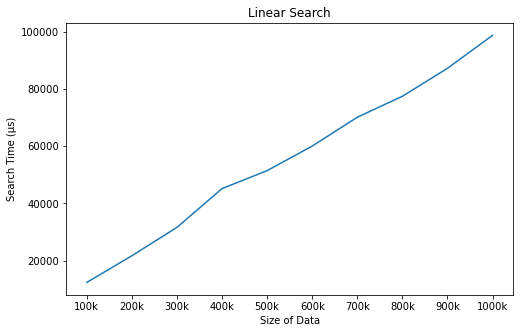

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
x = list(linear_search_time)
y = linear_search_time.values()
xlabel = [str(int(i/1000)) + 'k' for i in x]
ax.plot(x,y)
ax.set_xticks(x)
ax.set_xticklabels(xlabel)

ax.set_title('Linear Search')
ax.set_xlabel('Size of Data')
ax.set_ylabel('Search Time (μs)')

plt.show()

# Hash Table (Implementation)

Now let us implement the hashtable variation of our scenario and see how it compares to the linear search

In [28]:
def empty_hashtable(buckets):
    """
    Function takes number of buckets and returns a list of buckets size empty list
    Parameters:
        buckets: int
    Returns:
        Return value is list of empty lists.
        ReturnValue: list[list[]]
    """
    lol = []
    for i in range(buckets):
        lol.append([])
    return lol

In [65]:
def hash_function(key):
    """
    Function takes a key value and returns a hash code value for that key.
    Parameters:
        key: str
    Returns:
        ReturnValue: int
        Return value is the hash code of the function
    """
    h = 0
    key = key.lower()
    for a in key:
        h = ((h * ord(a))) % 2147483647 + ord(a)
        # Dividing to stop the hash code from going excessively
        # and arbritrary large
        # Dividing by a prime to evenly space the hash code distributions
        # Interesting fact: 2147483647 is the 8th Mersenne Prime.
        # hash code is returned
    return h

In [66]:
hash_function(GAME_OF_THRONES_BOOK)

948764657

In [67]:
empty = empty_hashtable(5)

In [68]:
empty

[[], [], [], [], []]

In [80]:
hash_function()  % 5

0

In [71]:
empty[0].append(('Rushil','M'))

In [72]:
empty

[[('Rushil', 'M')], [], [], [], []]

In [32]:
def populate_hashtable(list_of_tups, buckets):
    """
    Function takes a list of tuples (of two strings, books and authors),
    and buckets to populate a hashtable
    Parameters:
        list_of_tups: list[tup[str,str]]
        buckets: int
    ReturnValue:
        required_ht: list[list[str,str]]
    ReturnValue is the populated hashtable of list of lists
    """
    required_ht = empty_hashtable(buckets)
    for entry in list_of_tups:
        book = entry[0]
        author = entry[1]
        hashcode_book = hash_function(book)
        bucket_book = hashcode_book % buckets
        required_ht[bucket_book].append(entry)
    return required_ht

In [73]:
built_hashtable = populate_hashtable(all_books_and_authors, 10_000)

In [74]:
def find_in_hashtable(given_ht, value_to_find):
    """
    Function takes the hashtable and value_to_find as paramter inputs
    to look for the value_to_find in the hash
    table, return the tuple if it finds it, else return (-1,-1)
    Parameters:
        given_ht: list[list[str,str]]
        value_to_find: str
    ReturnValue:
        entry: (str,str)
            : (-1,-1) if entry in hashtable is not found
    """
    hashcode_tofind = hash_function(value_to_find)
    buckets_ht = len(given_ht)
    bucket_tofind = hashcode_tofind % buckets_ht
    for entry in given_ht[bucket_tofind]:
        if entry[0] == value_to_find:
            return entry
    return (-1, -1)

In [75]:
find_in_hashtable(built_hashtable, GAME_OF_THRONES_BOOK)

('a game of thrones (a song of ice and fire, book 1)', 'george r.r. martin')

In [76]:
%%timeit
find_in_hashtable(built_hashtable, GAME_OF_THRONES_BOOK)

12.1 µs ± 14.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [41]:
with open('experiments_time_hashfinds_final.pickle','rb') as f:
    hashtable_search_time = (pickle.load(f))

In [47]:
max_time = round(hashtable_search_time[1000000][1] * 1.10, -4)

list_size = list(hashtable_search_time)
bins_ = list(hashtable_search_time[list_size[0]])


def hash_plot(bin_size):
    """Plotting function used to display time
    complexity of hashtable using ipywidgets"""
    fig, ax = plt.subplots(figsize=(8, 5))
    x = list_size
    y = [hashtable_search_time[i][bin_size] for i in list_size]
    ax.plot(x, y)
    hash_title = 'Hashtable Search with {} bins'.format(bin_size)
    ax.set_title(hash_title)
    ax.set_ylim(0, max_time)
    ax.set_xlabel('Size of Data')
    ax.set_ylabel('Search Time (μs)')
    plt.show()


bin_size = widgets.Dropdown(
    options=[1,2,3,4,5,8,10,50,100,1000],
    value=1,
    description='Number:',
    disabled=False,
)

ui = widgets.VBox([bin_size])
out1 = widgets.interactive_output(hash_plot, {'bin_size':bin_size})
tab  = widgets.Tab(children = [out1])
display(ui,tab)

Here we can see that as we increase our bin size, the time taken to find an item in our hashtable decreases significanly. At 1 bin, the hashtable performs very similarly to a linear search, but at a 1000 bins, the improvement in time is incredibly significant. 

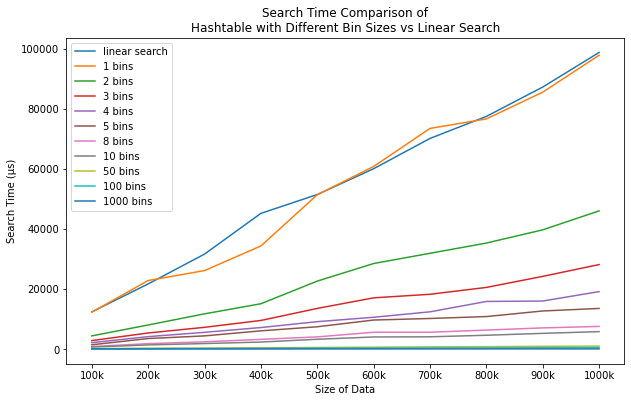

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

linear_x = list(linear_search_time)
linear_y = linear_search_time.values()

ax.plot(linear_x, linear_y, label='linear search')

list_size = list(hashtable_search_time)
bins_ = list(hashtable_search_time[list_size[0]])


for bucket in bins_:
    x = list_size
    y = [hashtable_search_time[i][bucket] for i in list_size]
    xlabel = [str(int(i / 1000)) + 'k' for i in x]
    ax.set_xticks(x)
    ax.set_xticklabels(xlabel)
    ax.plot(x, y, label=f'{bucket} bins')

my_plot_title = """Search Time Comparison of
Hashtable with Different Bin Sizes vs Linear Search"""

ax.set_title(my_plot_title)
ax.set_xlabel('Size of Data')
ax.set_ylabel('Search Time (μs)')
ax.legend()

plt.show()

Here is an overall search time comparison of linear search and hashtables. After seeing this improvement, I think it is fair to say that hashtables are definitely worth implementing!

# Conclusion

To conclude, hashtables are worthwhile data structures to consider when tackling any data science problem. They can be applied to a wide range of problems and will save you a lot of time and effort. You might think it is a lot of trouble to implement when on a smaller scale, but once you start working with bigger and bigger sets of data, you'll realize how useful they really are.